# Imports

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix
from collections import Counter
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import itertools
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
len(gpus)

1

# Data Loading

In [3]:
#directory of the dataset
DATA_DIR = 'NWPU-nature' 

#size of the image (images will be resized to these sizes)
img_height = 128
img_width = 128

#size of the batch
batch_size = 32

In [4]:
data = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7000 files belonging to 10 classes.
Metal device set to: Apple M1


2023-03-15 00:37:55.026650: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-15 00:37:55.026677: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Classes in the dataset

In [5]:
class_names = data.class_names
num_classes = len(class_names)
print(class_names)

['beach', 'chaparral', 'circular_farmland', 'desert', 'forest', 'island', 'lake', 'sea_ice', 'snowberg', 'terrace']


### Size of the subsets

In [6]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [7]:
train = data.take(int(train_size))
val = data.skip(train_size).take(int(val_size))
test = data.skip(train_size+val_size).take(int(test_size))

print(f'Size of the training set: {len(train)*batch_size}')
print(f'Size of the validation set: {len(val)*batch_size}')
print(f'Size of the testing set: {len(test)*batch_size}')

Size of the training set: 4896
Size of the validation set: 1408
Size of the testing set: 704


### Balance of the dataset
Merging label batches to check balance of the dataset

In [8]:
to_flat = []
for batch in data.as_numpy_iterator():
    to_flat.append(batch[1])

flat_list = list(itertools.chain(*to_flat))
len(flat_list)

2023-03-15 00:37:55.083306: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


7000

### Plotting the number of instances
(right now its equally distributed but it is not always the case)

<bound method Axes.plot of <Axes: title={'center': 'Numbers of classes'}, ylabel='count'>>

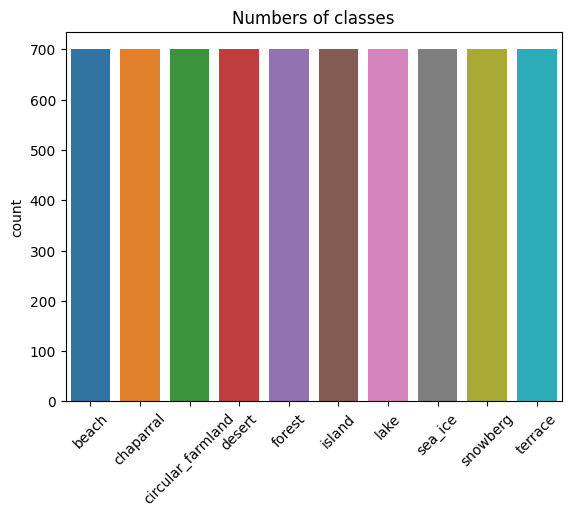

In [9]:
g = sns.countplot(x=flat_list)
g.set_xticklabels(class_names)
g.set_title('Numbers of classes')
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.plot

### Shape of the images
should be: img_width (128) x img_height (128) x RGB pixels values (3)

In [10]:
for image_batch, labels_batch in train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 128, 128, 3)
(32,)


### Saving the shape to the variable to make code more flexible

In [11]:
shape = image_batch.shape[1:]
shape

TensorShape([128, 128, 3])

### Plotting sample images

In [12]:
image_batch,label_batch= next(iter(train))

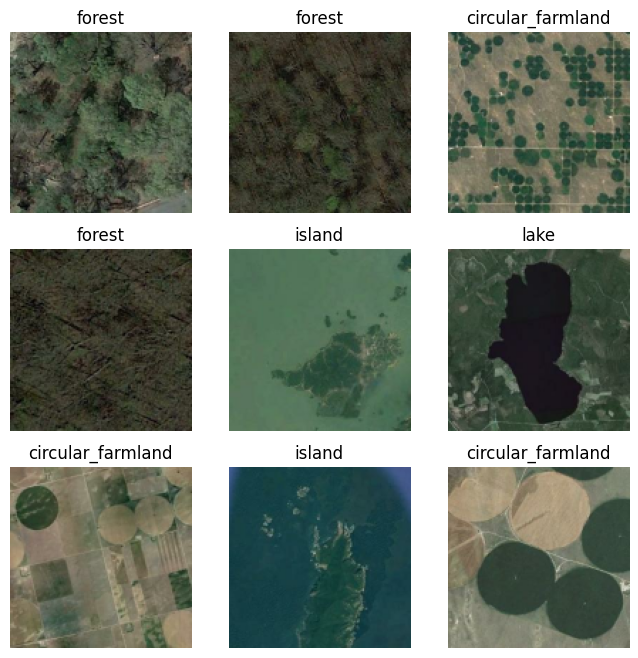

In [13]:
fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = image_batch[i]/255
    fig.add_subplot(rows, columns, i)
    plt.title(class_names[int(label_batch[i])])
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train= train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)
test = test.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
normalization_layer = tf.keras.layers.Rescaling(scale=1./255)

# Model 

In [16]:
model = tf.keras.Sequential([

  normalization_layer, 

  tf.keras.layers.Resizing(
  img_height,
  img_width,
  interpolation='bilinear',crop_to_aspect_ratio=True),

  tf.keras.layers.Conv2D(64, (3,3), 1, padding='same', activation='relu', input_shape=shape),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2,2)),
  
  tf.keras.layers.Conv2D(128, (3,3),1,padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2,2)),  
  
  tf.keras.layers.Conv2D(128, (3,3),1,padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2,2)),
  
  tf.keras.layers.Conv2D(256, (3,3),1,padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D((2,2)),
  
  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(num_classes,activation='softmax')
])

In [17]:
model.compile(
  optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [18]:
model.build(input_shape=(None,img_height,img_width,3))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 resizing (Resizing)         (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       7

### Saving model logs to directory

In [19]:
log_dir = 'logs'

In [20]:
tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

### Early stopping
stopping the model if val_loss after 5th epoch is not decreasing 4 epochs in a row

In [21]:
early_stopping= EarlyStopping(monitor='val_loss', patience=4,start_from_epoch=5,restore_best_weights=True)

### ReduceLROnPlateau

In [22]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.00001,mode='min')

# Model training

In [23]:
hist = model.fit(
  train,
  validation_data=val,
  epochs=30,
  callbacks=[tensorflow_callback,early_stopping,reduce_lr],
  verbose=1
)

Epoch 1/30


2023-03-15 00:37:57.280749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


153/153 [==============================] - ETA: 0s - loss: 3.9194 - accuracy: 0.6383

2023-03-15 00:38:31.344849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


153/153 [==============================] - 38s 247ms/step - loss: 3.9194 - accuracy: 0.6383 - val_loss: 4.6989 - val_accuracy: 0.1527 - lr: 0.0010
Epoch 2/30
153/153 [==============================] - 35s 231ms/step - loss: 0.7262 - accuracy: 0.8170 - val_loss: 6.1372 - val_accuracy: 0.1428 - lr: 0.0010
Epoch 3/30
153/153 [==============================] - 34s 221ms/step - loss: 0.4721 - accuracy: 0.8611 - val_loss: 2.7917 - val_accuracy: 0.4496 - lr: 0.0010
Epoch 4/30
153/153 [==============================] - 35s 226ms/step - loss: 0.2819 - accuracy: 0.9118 - val_loss: 0.6731 - val_accuracy: 0.8118 - lr: 0.0010
Epoch 5/30
153/153 [==============================] - 34s 222ms/step - loss: 0.2003 - accuracy: 0.9400 - val_loss: 1.0010 - val_accuracy: 0.7393 - lr: 0.0010
Epoch 6/30
153/153 [==============================] - 35s 227ms/step - loss: 0.2702 - accuracy: 0.9203 - val_loss: 0.9387 - val_accuracy: 0.8189 - lr: 0.0010
Epoch 7/30
153/153 [==============================] - 35s 226ms

### Plotting training loss and validation loss

<Figure size 640x480 with 0 Axes>

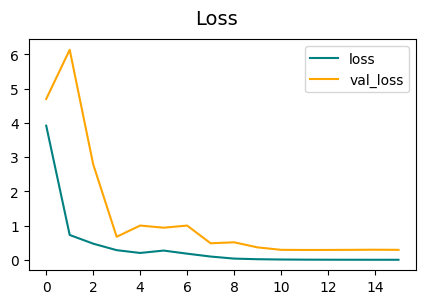

In [24]:
fig = plt.figure()

plt.figure(figsize=(5, 3))

plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')

plt.suptitle('Loss',fontsize=14)
plt.legend(loc='upper right')
plt.show()

### Plotting training accuracy and validation accuracy

<Figure size 640x480 with 0 Axes>

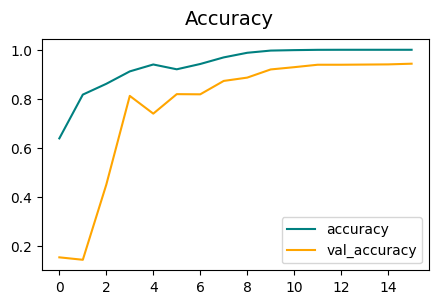

In [25]:
fig = plt.figure()
plt.figure(figsize=(5, 3))

plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')

plt.suptitle('Accuracy',fontsize=14)
plt.legend(loc='lower right')
plt.show()

In [26]:
model.evaluate(test)

22/22 [==============================] - 3s 57ms/step - loss: 0.2381 - accuracy: 0.9382


[0.2381361871957779, 0.9382184147834778]

# Confusion Matrix
since confusion matrix cannot handle batches they are unpacked into the arrays

In [27]:
predcs = []
labels = []
batches=[]

for batch in test.as_numpy_iterator():
    batches.append(batch)
    
for next_batch in batches:
    for pred in next_batch[0]:
        predcs.append(pred)
    for label in next_batch[1]:
        labels.append(label)

predcs = np.asarray(predcs)
labels = np.asarray(labels)

In [28]:
y_pred = np.array(model.predict(predcs))
y_true = np.array(labels)

 3/22 [===>..........................] - ETA: 0s

2023-03-15 00:47:15.934629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 1s 60ms/step


In [29]:
pred_max = []
for x in y_pred:
    pred_max.append(np.argmax(x))

y_pred = pred_max

In [30]:
counter = Counter(y_true)

print('Number of instances per class in the testing set \n')
for label, num in sorted(counter.items()):
    print(f'{class_names[label]}: {num}')

Number of instances per class in the testing set 

beach: 60
chaparral: 65
circular_farmland: 84
desert: 72
forest: 75
island: 76
lake: 64
sea_ice: 66
snowberg: 70
terrace: 64


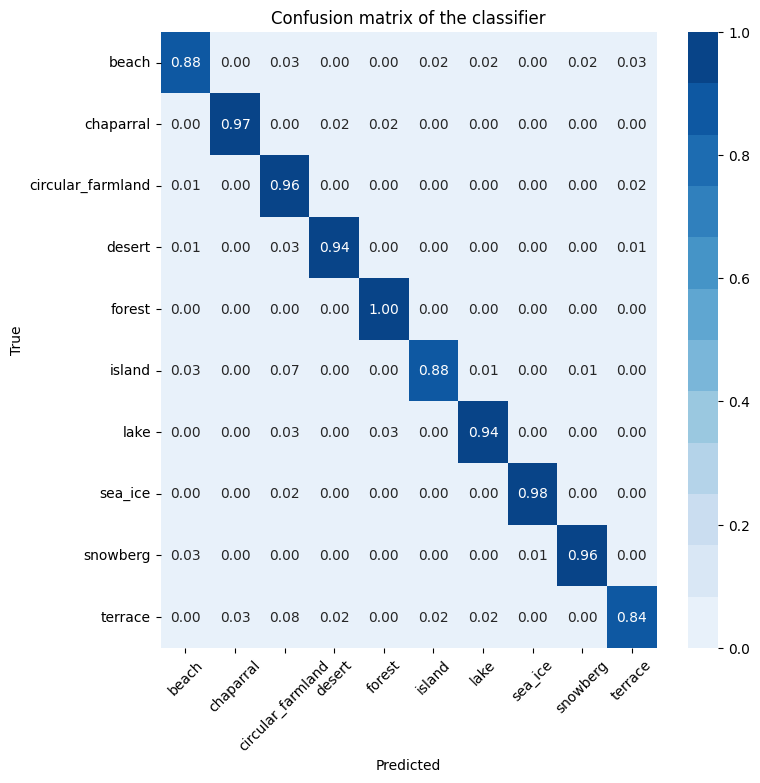

In [31]:
cm= confusion_matrix(y_true,y_pred,normalize='true')

plt.figure(figsize=(8,8))
plt.title('Confusion matrix of the classifier')
sns.heatmap(cm,
            annot=True, 
            fmt=".2f",
            cmap=sns.color_palette("Blues",12),
            yticklabels=class_names,
            xticklabels=class_names)

plt.xticks(rotation=45)
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

### Plotting images from testing dataset with predicted labels

In [32]:
X_test = batches[0][0]
y_test = batches[0][1]

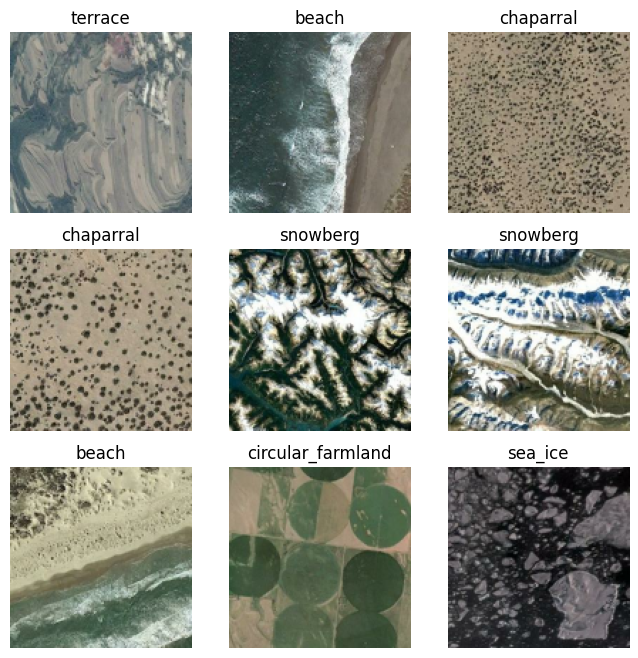

In [33]:
fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = normalization_layer(X_test[i])
    fig.add_subplot(rows, columns, i)
    plt.title(class_names[y_pred[i]])
    plt.axis("off")
    plt.imshow(img)
plt.savefig('predictions/prediction.png')
plt.show()